<a href="https://colab.research.google.com/github/AbdelrahmanTamer11/Object-Detection-on-Custom-Dataset-/blob/main/object_detection_on_car_object_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloning into 'yolov5'...
remote: Enumerating objects: 17022, done.
remote: Total 17022 (delta 0), reused 0 (delta 0), pack-reused 17022 (from 1)
Receiving objects: 100% (17022/17022), 15.62 MiB | 26.34 MiB/s, done.
Resolving deltas: 100% (11695/11695), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 7.2 MB/s eta 0:00:00a 0:00:01
             image        xmin        ymin        xmax        ymax  \
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547   
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180   
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180   
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575   
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422   

      image_id  x_center  y_center         w         h  classes  
0   vid_4_1000  0.450434  0.539817  0.068741  0.095238        0  
1  vid_4_10000  0.100217  0.557191  0.155572  0.129987        0  
2  vid_4_10040  0.444645  0.54367

  0%|          | 0/355 [00:00<?, ?it/s]

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
detect: weights=['yolov5/yolov5s.pt'], source=/kaggle/input/car-object-detection/data/testing_images, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)

100%|██████████████████████████████████████| 14.1M/14.1M [00:00<

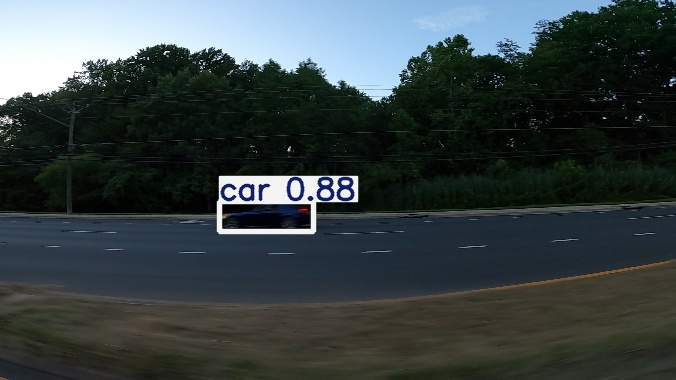

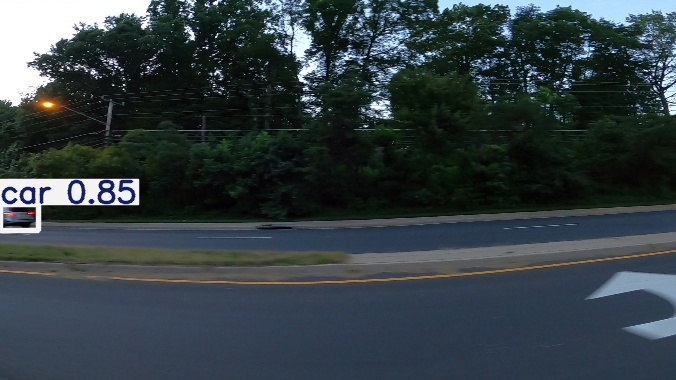

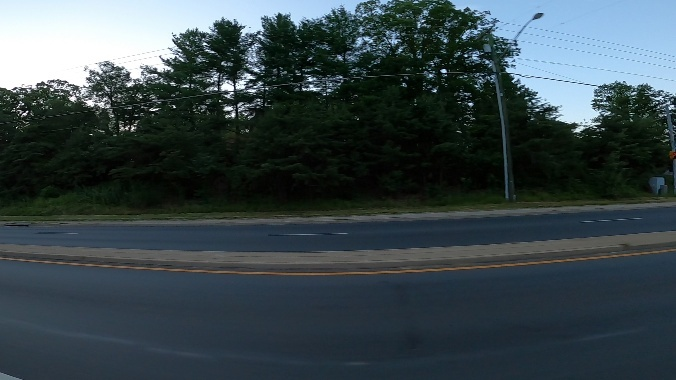

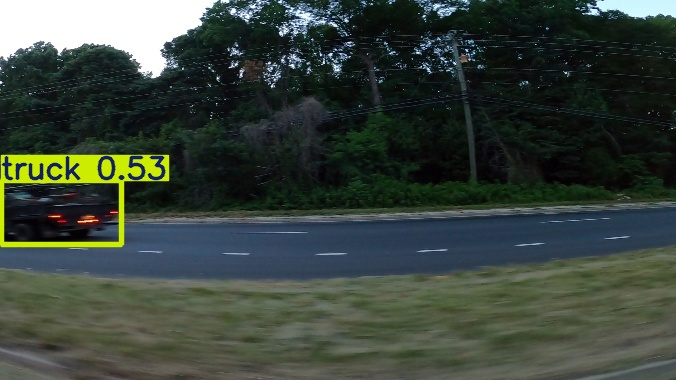

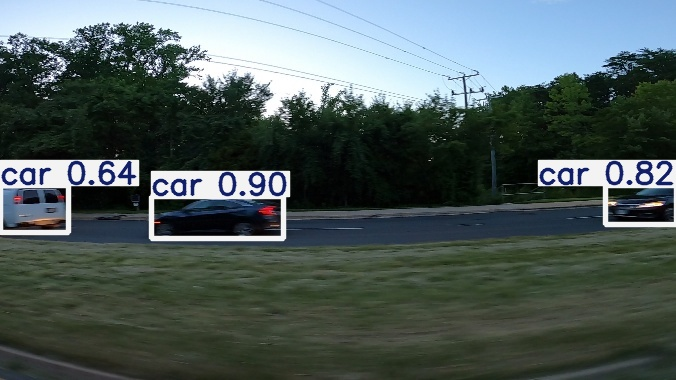

In [ ]:
import os
import random
import pandas as pd
import cv2
import shutil as sh
from tqdm.auto import tqdm
from IPython.display import Image
import matplotlib.pyplot as plt



In [ ]:
# Clone and install YOLOv5 requirements (only needs to be done once)
!git clone https://github.com/ultralytics/yolov5
!pip install -U pycocotools
!pip install -qr yolov5/requirements.txt



fatal: destination path 'yolov5' already exists and is not an empty directory.


In [ ]:
# Image and dataframe setup
img_dims = (380, 676)  # (height, width)
df = pd.read_csv('../input/car-object-detection/data/train_solution_bounding_boxes (1).csv')
df['image_id'] = df['image'].str.split('.').str[0]
df['x_center'] = (df['xmin'] + df['xmax']) / 2 / img_dims[1]
df['y_center'] = (df['ymin'] + df['ymax']) / 2 / img_dims[0]
df['w'] = (df['xmax'] - df['xmin']) / img_dims[1]
df['h'] = (df['ymax'] - df['ymin']) / img_dims[0]
df['classes'] = 0
print(df.head())




             image        xmin        ymin        xmax        ymax  \
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547   
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180   
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180   
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575   
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422   

      image_id  x_center  y_center         w         h  classes  
0   vid_4_1000  0.450434  0.539817  0.068741  0.095238        0  
1  vid_4_10000  0.100217  0.557191  0.155572  0.129987        0  
2  vid_4_10040  0.444645  0.543678  0.181621  0.157014        0  
3  vid_4_10020  0.833213  0.531451  0.197540  0.155727        0  
4  vid_4_10060  0.110347  0.559122  0.171491  0.136422        0  


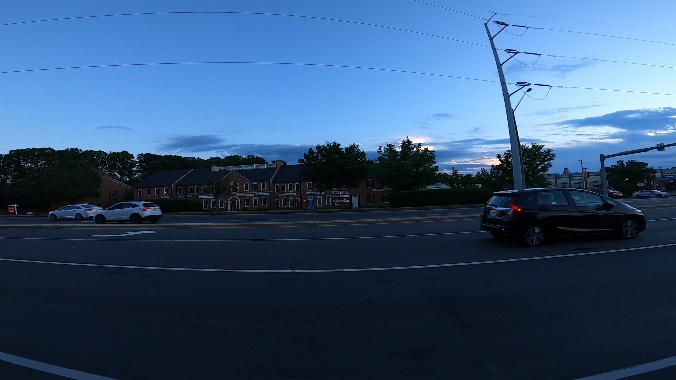

In [ ]:
# Display a random training image
random_image = random.choice(df['image_id'].unique())
Image(filename=f'/kaggle/input/car-object-detection/data/training_images/{random_image}.jpg', width=600)



In [ ]:
# Organize data into train/val folders
output_base = '/tmp/convertor/fold0/'
for name, mini_df in tqdm(df.groupby('image_id')):
    is_validation = name in df['image_id'].sample(frac=0.2).values  # 20% as validation
    set_type = 'val2017' if is_validation else 'train2017'

    label_dir = os.path.join(output_base, 'labels', set_type)
    image_dir = os.path.join(output_base, 'images', set_type)
    os.makedirs(label_dir, exist_ok=True)
    os.makedirs(image_dir, exist_ok=True)

    # Save labels
    mini_df[['classes', 'x_center', 'y_center', 'w', 'h']].to_csv(f"{label_dir}/{name}.txt", header=False, index=False, sep=' ')

    # Copy image
    src_img = f"/kaggle/input/car-object-detection/data/training_images/{name}.jpg"
    dst_img = f"{image_dir}/{name}.jpg"
    sh.copy(src_img, dst_img)



  0%|          | 0/355 [00:00<?, ?it/s]

In [ ]:
# Run YOLOv5 detection on testing images
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /kaggle/input/car-object-detection/data/testing_images



detect: weights=['yolov5/yolov5s.pt'], source=/kaggle/input/car-object-detection/data/testing_images, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
WARNING ⚠️ --img-size [676, 676] must be multiple of max stride 32, updating to [704, 704]
image 1/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25100.jpg: 416x704 (no detections), 28.4ms
image 2/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_251

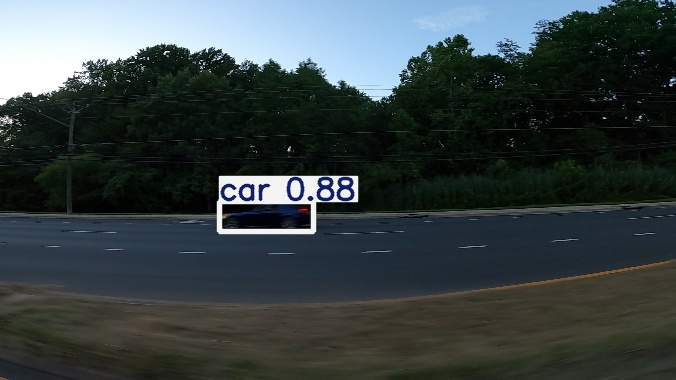

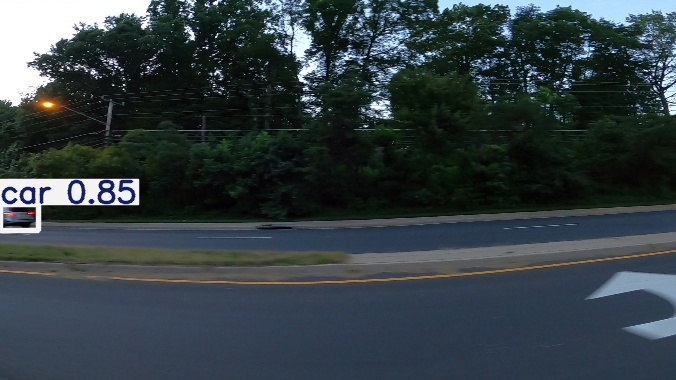

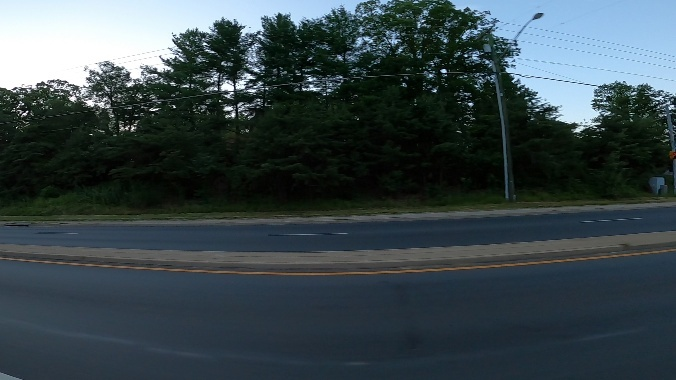

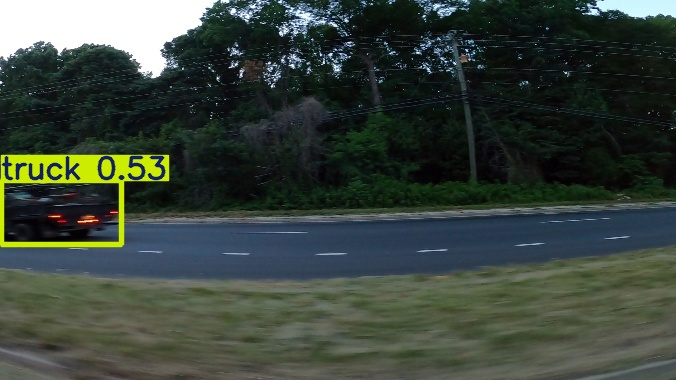

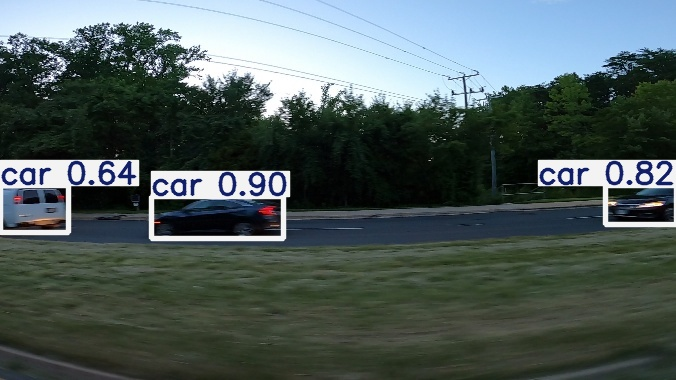

In [ ]:
# Display predictions
for filename in ["vid_5_29400.jpg", "vid_5_29580.jpg", "vid_5_30720.jpg", "vid_5_28540.jpg", "vid_5_26740.jpg"]:
    display_path = f'/kaggle/working/yolov5/runs/detect/exp/{filename}'
    display(Image(filename=display_path))